# Tutorial: Training a MoGP model

This notebook provides a guide on how to load/normalize data, train a MoGP, and interact with the model. 

In [1]:
%matplotlib inline

import numpy as np
import joblib
import matplotlib
import matplotlib.pyplot as plt

import mogp

## Load data
MoGP priors are scaled to assume that Y has been z-score normalized, and that X values are provided in years.

**X** (np.ndarray): explanatory variable (time since symptom onset, in years)  

**Y** (np.ndarray): responses (clinical scores)  

**Matrix size for X and Y:** N x T (N - # patients, T - # time points)   
If participants have varying number of clinical visits, set # time points to max number of visits, and pad end of arrays with fewer visits with NaN values

**Onset Anchor:** If desired, add onset anchor (artificial datapoint at date of symptom). 
If chose to not add onset anchor, set MoGP onset_anchor flag=False when training MoGP

In [2]:
X, Y = mogp.utils.generate_toy_data(seed=0)

# Add onset anchor to matrix
num_pat = X.shape[0]
onset_anchor = 48 # normal onset anchor for ALSFRS-R scores
X = np.hstack((np.zeros((num_pat,1)), X))
Y = np.hstack((onset_anchor * np.ones((num_pat,1)), Y))

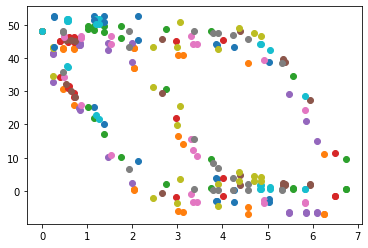

In [3]:
# Visualize Toy Data
for i in range(num_pat):
    _ = plt.plot(X[i], Y[i], 'o')

## Train MoGP model
MoGP model requires X, Y, and alpha as parameters

**alpha** (float): Dirichlet Process scaling parameter; can influence the degree of cluster discretization and therefore the number of identified clusters.  
To estimate alpha, we use ``` alpha = number_init_clusters / np.log10(number_patients) ```, where `number_init_clusters` is a rough guess at number of clusters that may be present in data. The actual number of clusters will be optimized through model training. 

In [4]:
# Provide output directory for model
save_dir = './test'

In [5]:
# Train model
mix = mogp.MoGP_constrained(X=X, Y=Y, alpha=1., num_iter=10, savepath=save_dir, rand_seed=0, normalize=True)
mix.sample()

04:47:10 - MOGP: INFO - Cluster Initialization: [30  6 12  6  6]
04:47:10 - MOGP: INFO - Saved Model: /Users/divyar/Documents/Grad - Divya/Research/mogp/example/test/MoGP_constrained_iterinit.pkl
04:47:13 - MOGP: INFO - Iter 1: [41  2  3 14]
04:47:15 - MOGP: INFO - Iter 2: [33  3  1 23]
04:47:17 - MOGP: INFO - Iter 3: [23 15 22]
04:47:18 - MOGP: INFO - Iter 4: [21 16 23]
04:47:19 - MOGP: INFO - Iter 5: [19 20 21]
04:47:21 - MOGP: INFO - Iter 6: [20 19 21]
04:47:22 - MOGP: INFO - Iter 7: [21 19 20]
04:47:23 - MOGP: INFO - Iter 8: [20 19 21]
04:47:25 - MOGP: INFO - Iter 9: [21 19 20]
04:47:25 - MOGP: INFO - Saved Model: /Users/divyar/Documents/Grad - Divya/Research/mogp/example/test/MoGP_constrained.pkl


# Interact with model

MoGP consists of two modules: allocmodel and obsmodel. Relevant fields for each listed below.

**allocmodel** stores properties of the Dirichlet process (DP) clustering model (ex: cluster ids, number of participants in each cluster).   
- alpha (float): DP concentration prior
- Nk (np.array): List of the number of clusters in each cluster component in DP model.
- N (int): Total number of patients in model training data

**obsmodel** stores properties of each cluster's specific Gaussian process regression models. obsmodel is a dictionary of all cluster components, indexed by cluster id (Ex: to access the GP model of a specific cluster, use ```obsmodel[cluster_id].model```)
- model (GPy model object): obsmodel is built off of [GPy](https://sheffieldml.github.io/GPy/) and GPy functions can be used on the model object of a specific cluster
- ll (float): GP regression model log likelihood


### Get number of clusters and their IDs

In [6]:
# Only get cluster IDs if the cluster has at least 1 participant included; disregard all cluster components that have no participants
active_cluster_ids = np.where(mix.allocmodel.Nk>0)[0]
print('Model has {} clusters'.format(len(active_cluster_ids)))
print('Active Cluster IDs: {}'.format(active_cluster_ids))

Model has 3 clusters
Active Cluster IDs: [0 1 3]


### Visualize clusters in MoGP

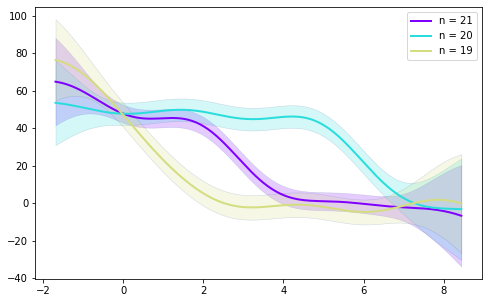

In [7]:
# Legend indicates number of participants in each cluster
fig, ax = plt.subplots(figsize=(8,5))
ax = mogp.utils.plot_mogp(ax=ax, model=mix)

### Use GPy methods to interact with model
obsmodel is a dictionary of GPy models; accessing the model field of a obsmodel cluster allows you to use all of [GPy's](https://sheffieldml.github.io/GPy/) functions

In [8]:
# Get the learned Gaussian Process parameters for one of the cluster, using its active cluster ID
cur_clust = active_cluster_ids[0]
mix.obsmodel[cur_clust].model

GP_regression.,value,constraints,priors
neg_linmap.A,[0.28341388],+ve,"Ga(2.2, 3.3)"
rbf.variance,1.0,+ve fixed,
rbf.lengthscale,1.5770597538950126,+ve,"Ga(1.8, 0.44)"
Gaussian_noise.variance,0.013348237935366946,+ve,"Ga(9, 12)"


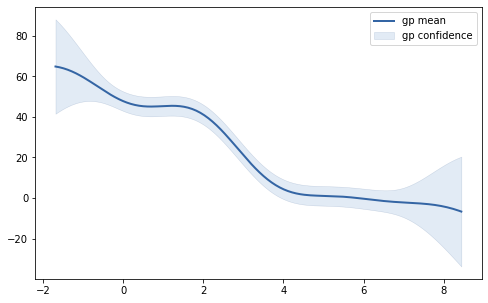

In [9]:
# Plot mean function of this cluster
fig, ax = plt.subplots(figsize=(8,5))
_ = mix.obsmodel[cur_clust].model.plot_mean(ax=ax)
_ = mix.obsmodel[cur_clust].model.plot_confidence(ax=ax)